### Heston Model

The Heston model describes the evolution of a stock price $S_t$ whose variance $V_t$ is given by a mean reverting square root process:

\begin{eqnarray}
\frac{dS_t}{S_t} &=& \mu dt  + \sqrt{V_t}dW_t^{1},\\
dV_t &=& \kappa(\theta - V_t)dt  + \sigma \sqrt{V_t}dW_t^{2}.
\end{eqnarray}

A key characteristic of the model is that the Wiener processes are correlated $dW_t^{1}\cdot dW_t^{2}=\rho dt$. This feature enables the model to exhibit the 'leverage effect'. 

### Jump Diffusion Models: Bates Method

The Bates Jump-Diffusion model [BATES1993] is specified as the following set of coupled stochastic differential equations

\begin{equation}
\frac{dS_t}{S_t} = \mu dt  + \sqrt{V_t}dW_t^{1} + (Y-1)S_tdN_t,
\end{equation}
\begin{equation}
dV_t = \kappa(\theta - V_t)dt  + \sigma \sqrt{V_t}dW_t^{2},
\end{equation}

describing the evolution of a stock price $S_t$ whose variance $V_t$ is given by a mean reverting square root process which ensures that the variance is always positive provided that $2\kappa\theta - \sigma^2>0$. $N_t$ is a standard Poisson process with intensity $\lambda>0$ and $Y$ is the log-normal jump size distribution with mean $\mu_j=ln (1+a) - \frac{\sigma_j^2}{2},~a>-1$ and standard deviation $\sigma_j \geq 0$. 

Both $N(t)$ and $Y$ are independent of the Wiener processes $W_t^{1}$ and $W_t^{2}$.  A key characteristic of the model, which originates from the embedded Heston stochastic volatility diffusion model, is that the Wiener processes are correlated $dW_t^{1}\cdot dW_t^{2}=\rho dt$. This feature enables the model to exhibit the leverage effect. Note that simply excluding the compound Poisson term $(Y-1)S_tdN_t$ recovers the Heston model.

## Pricing
With marginal loss of generality, we will restrict the scope of this section to European equity options. Stochastic volatility models permit semi-analytical closed-form solutions for computing risk neutral European option prices. The price can be represented as a weighted sum of the delta of the European call option $P_1$ and $P_2$ - the probability that the asset price will
exceed the strike price at maturity. Adopting standard option pricing notation, the call price of a vanilla European option is

\begin{equation}
 C(S_0, K,\tau; \mathbf{z}_0) = S_0P_1 - K\exp\{-(r-q )\tau\}P_2,
\end{equation}

$P_1$ and $P_2$ can be expressed as:

\begin{equation}
P_j =\frac{1}{2} + \frac{1}{\pi} \int_{o}^{\infty} \text{Re}\left[\frac{\exp\{-iu ln K\}\phi_j (S_0,\tau,u; \mathbf{z}_0)}{iu}\right]du, j=1,2.
\end{equation}

where $\phi_j$ are Heston analytic characteristic functions and $\mathbf{z}_0$ is the vector of Heston model parameters.  

### Fourier-Cosine Method
An alternative approach to the Carr-Madan FFT approach is to use the Fourier-Cosine Method. Following Fang and Oosterlee [FANG2008], the entire inverse Fourier integral in the pricing equation is reconstructed from Fourier-cosine series expansion of the integrand to give the following approximation of the call price
\begin{equation}
C(S_0, K, \tau; \mathbf{z}_0) \approx Ke^{-r\tau} \cdot \text{Re}\{\sum_{k=0}^{N-1}'\phi\left(\frac{k\pi}{b-a};\mathbf{z}_0\right)e^{ik\pi\frac{x - a}{b-a}}U_k\},
\end{equation}
where $x:= ln(S_0/K)$ and $\phi(w;\mathbf{z}_0)$ denotes the characteristic function of the log-asset price, $U_k$ the payoff series coefficients and $N$ denotes the number of terms in the cosine series expansion (typically 128 will suffice). 

For the approximation of the Heston model call price, the Fourier-Cosine approach is shown to be superior in convergence properties to other FFT and quadrature based methods in [DIXON2013].


<img src="error_convergence.png">

In [1]:
from random import Random
from numpy import *
from scipy import *
from time import *
from datetime import *
import numpy as np
import sys
import csv

%matplotlib inline

In [2]:
### Implement the Fourier-Cosine Method
def HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, otype, N=256):
    c1 = r*T+(1-exp(-lmbda*T))*(meanV-v0)/(2.0*lmbda)-0.5*meanV*T
    c2 = 1.0/(8.0*lmbda**3)*(sigma*T*lmbda*exp(-lmbda*T)*(v0-meanV)*(8.0*lmbda*rho-4.0*sigma)+lmbda*rho*sigma*(1-exp(-lmbda*T))*(16.0*meanV-8.0*v0)+2.0*meanV*lmbda*T*(-4.0*lmbda*rho*sigma+sigma**2+4.0*lmbda**2)+sigma**2*((meanV-2.0*v0)*exp(-2.0*lmbda*T)+meanV*(6.0*exp(-lmbda*T)-7.0)+2.0*v0)+8.0*lmbda**2*(v0-meanV)*(1-exp(-lmbda*T)))
    a = c1-12.0*sqrt(abs(c2))
    b = c1+12.0*sqrt(abs(c2))
    x = log(float(S)/K)
    k = arange(0,N)
    if (otype == 'C'):
       U = 2.0/(b-a)*(xi(k,a,b,0,b) - psi(k,a,b,0,b))
    else:
       U = 2.0/(b-a)*(-xi(k,a,b,a,0) + psi(k,a,b,a,0))   
    unit = [1.0] * N
    unit[0] = 0.5
    ret = 0
# Note that HestonCF is independent of the strike
    HCF = HestonCF(k*pi/(b-a),T,r,sigma,lmbda,meanV,v0,rho)
    for i in range(N):
      ret += unit[i]*HCF[i]*exp(1j*float(k[i])*pi*(x-a)/(b-a))*U[i]
    return K*exp(-r*T)*ret.real

def HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, otype, N=256):
    c1 = r*T+(1-exp(-lmbda*T))*(meanV-v0)/(2.0*lmbda)-0.5*meanV*T
    c2 = 1.0/(8.0*lmbda**3)*(sigma*T*lmbda*exp(-lmbda*T)*(v0-meanV)*(8.0*lmbda*rho-4.0*sigma)+lmbda*rho*sigma*(1-exp(-lmbda*T))*(16.0*meanV-8.0*v0)+2.0*meanV*lmbda*T*(-4.0*lmbda*rho*sigma+sigma**2+4.0*lmbda**2)+sigma**2*((meanV-2.0*v0)*exp(-2.0*lmbda*T)+meanV*(6.0*exp(-lmbda*T)-7.0)+2.0*v0)+8.0*lmbda**2*(v0-meanV)*(1-exp(-lmbda*T)))
    a = c1-12.0*sqrt(abs(c2))
    b = c1+12.0*sqrt(abs(c2))
    x = log(float(S)/K)
    k = arange(0,N)
    if (otype == 'C'):
       U = 2.0/(b-a)*(xi(k,a,b,0,b) - psi(k,a,b,0,b))
    else:
       U = 2.0/(b-a)*(-xi(k,a,b,a,0) + psi(k,a,b,a,0))   
    unit = [1.0] * N
    unit[0] = 0.5
    ret = 0
# Note that HestonCF is independent of the strike
    HCF = HestonCFdu0(k*pi/(b-a),T,r,sigma,lmbda,meanV,v0,rho)
    for i in range(N):
      ret += unit[i]*HCF[i]*exp(1j*float(k[i])*pi*(x-a)/(b-a))*U[i]
    return K*exp(-r*T)*ret.real


def HestonCF(u,T,r,sigma,lmbda,meanV,v0,rho):
    a = lmbda*meanV
    b = lmbda
    d = sqrt((1j*rho*sigma*u-b)**2+(u**2+1j*u)*sigma**2)
    g = (b-1j*rho*sigma*u-d)/(b-1j*rho*sigma*u+d)
    ret = exp(1j*u*r*T)
    ret = ret*exp((a/sigma**2)*((b - rho*1j*sigma*u - d)*T - 2.0*log((1-g*exp(-d*T))/(1-g))))
    return ret*exp((v0/sigma**2)*(b - rho*1j*sigma*u - d)*(1-exp(-d*T))/(1-g*exp(-d*T)))


# The Derivative of the Heston Characteristic Function w.r.t. to the v0 
def HestonCFdu0(u,T,r,sigma,lmbda,meanV,v0,rho):

    a = lmbda*meanV
    b = lmbda
    d = sqrt((1j*rho*sigma*u-b)**2+(u**2+1j*u)*sigma**2)
    g = (b-1j*rho*sigma*u-d)/(b-1j*rho*sigma*u+d)
    ret = exp(1j*u*r*T)
    
    ret = ret*exp((a/sigma**2)*((b - rho*1j*sigma*u - d)*T - 2.0*log((1.0-g*exp(-d*T))/(1.0-g))))
    ret = ret*exp((v0/sigma**2)*(b - rho*1j*sigma*u - d)*(1.0-exp(-d*T))/(1.0-g*exp(-d*T)))
    ret = ret *((1.0-exp(-d*T))/(1.0-g*exp(-d*T)))*(b-1j*rho*sigma*u-d)/(sigma**2)
    return(ret)



def xi(k,a,b,c,d):
    ret = 1.0/(1+(k*pi/(b-a))**2)*(cos(k*pi*(d-a)/(b-a))*exp(d)-cos(k*pi*(c-a)/(b-a))*exp(c)+k*pi/(b-a)*sin(k*pi*(d-a)/(b-a))*exp(d)-k*pi/(b-a)*sin(k*pi*(c-a)/(b-a))*exp(c))
    return ret

def psi(k,a,b,c,d):
    N = len(k)
    idx = arange(1, N)
    ret = array([0.0]*N)
    ret[0] = d-c
    ret[idx] =(sin(k[idx]*pi*(d-a)/(b-a))-sin(k[idx]*pi*(c-a)/(b-a)))*(b-a)/(k[idx]*pi)
    return ret



In [3]:
import matplotlib.pyplot as plt

In [4]:
nInt = 256
r0 = 0.0002

#p0 = [5.76145232379, 0.393696857573, 0.99999999,-0.686387364593,0.685888435264]
#print Error_Function(p0)

S= 100
K = 100
T = 0.01
r = r0
sigma = 0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
V= HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)

vegas = []
S_arr = np.arange(90,110,0.1)
for S in S_arr:
    vegas.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt));


Text(0,0.5,'vegas')

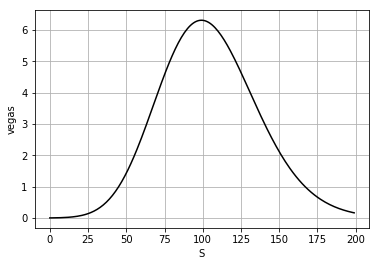

In [5]:
plt.figure(facecolor='white', edgecolor='black')
plt.grid(True)
plt.plot(vegas, color='black')
plt.xlabel('S')
plt.ylabel('vegas')

What if we just fit the regression to a smaller number of points

In [6]:
idx = np.arange(1,len(S_arr),40)

In [7]:
rg = np.polyfit(S_arr[idx], np.array(vegas)[idx], 4)
vegas_reg = np.polyval(rg, S_arr[idx])  # continuation values

Text(0,0.5,'vegas')

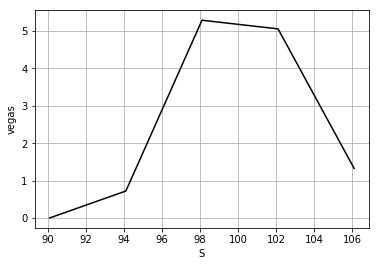

In [8]:
plt.figure(facecolor='white', edgecolor='black')
plt.grid(True)
plt.plot(S_arr[idx], vegas_reg, color='black')
plt.xlabel('S')
plt.ylabel('vegas')

What if I fit polynomial regression

In [9]:
x = S_arr[idx]
y = np.array(vegas)[idx]
p3=np.polyfit(x, y, 3)
p3_test = np.polyval(np.polyfit(x, y, 3), x)

In [10]:
def p3_func(x):
    ret = p3[0] * (x**3) + p3[1] * (x**2) + p3[2] * x + p3[3]
    return ret

In [11]:
poly_reg = []
for S in S_arr[idx]:
    poly_reg.append(p3_func(S))

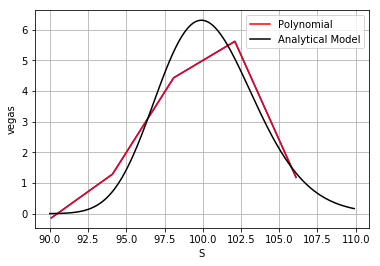

In [12]:
plt.figure(facecolor='white', edgecolor='black')
plt.plot(S_arr[idx], poly_reg, color='b') # calculated by p3_func above, overlapped with plot by np.polyval(...), same result.
plt.plot(S_arr[idx], p3_test, color = 'r', label = 'Polynomial') # calculated by np.polyval(...)
plt.plot(S_arr, vegas, color = 'black', label = 'Analytical Model') 
plt.xlabel('S')
plt.ylabel('vegas')
plt.grid(True)
plt.legend(loc = 'best', prop={'size':10})

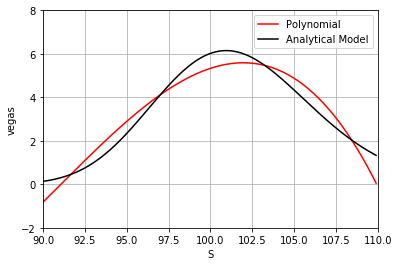

In [13]:
# tweak parameters
S_t= 100
K_t = 101
T_t = 0.014
r_t = r0
sigma_t = 0.5
lmbda_t = 0.1
meanV_t = 0.1
v0_t = 0.15
rho_t =-0.9
V_t= HestonCOS(S_t, K_t, T_t, r_t, sigma_t, lmbda_t, meanV_t, v0_t, rho_t, 'C', N=nInt)

vegas_tweak = []
S_arr = np.arange(90,110,0.1)
for S in S_arr:
    vegas_tweak.append(HestonVega(S, K_t, T_t, r_t, sigma_t, lmbda_t, meanV_t, v0_t, rho_t, 'C', N=nInt));

p3_tweak = np.polyval(np.polyfit(S_arr, np.array(vegas_tweak), 3), S_arr)

plt.figure(facecolor='white', edgecolor='black')
plt.grid(True)
plt.xlim(90, 110)
plt.xlabel('S')
plt.ylabel('vegas')
plt.plot(S_arr, p3_tweak, color='red', label = 'Polynomial')
plt.plot(S_arr, vegas_tweak, color = 'black', label = 'Analytical Model')
plt.ylim(-2,8)
plt.legend(loc = 'best', prop={'size':10})

# Apply GPR to Heston Vegas

In [15]:
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
from edward.models import Normal
import seaborn as sns
plt.style.use('ggplot')
from edward.models import MultivariateNormalTriL
from edward.util import rbf
import scipy
from scipy.optimize import minimize

# Define functions and set up data

In [16]:
def llk(x):
    l = np.float(x[0])
    noise_term = np.float(x[1])
    #print l, noise_term
    Kernel = rbf(train_x, lengthscale=l).eval()
    K_y = Kernel + np.eye(training_number) * noise_term 
    K_y_inv = np.linalg.inv(K_y)
    v_y= np.matmul(K_y_inv,train_y) 
    D= np.linalg.det(K_y)
    if abs(D)< 1e-10:
        D= 1e-10
    ret = - 0.5*np.dot(v_y.T, v_y) - 0.5*np.log(np.linalg.det(K_y)) -(training_number/2.0)*np.log(2.0*np.pi)
    return(-ret)

In [17]:
def llk2(x):
    l = np.float(x[0])
    noise_term = np.float(x[1])
    
    Kernel = rbf(train_x, lengthscale=l).eval()
    K_y = Kernel + np.eye(training_number) * noise_term 
    L = scipy.linalg.cho_factor(K_y)
    alpha = scipy.linalg.cho_solve(L, train_y)
    LF= np.linalg.cholesky(K_y) 
    LL = np.log(np.diag(LF))
    ret = - 0.5*np.dot(np.array(train_y).T, alpha) -np.sum(LL) -(training_number/2.0)*np.log(2.0*np.pi)
    print ret

In [18]:
bounds=[ [0.001,1.0],[0.001,0.1]   ]

#construct the bounds in the form of constraints
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)

# Data Generation Process

In [20]:
# Numerical prediction
sess = ed.get_session()
training_number = 20    # You can change the number to see training quality with different amount of training dataset 
train_x = np.array(np.linspace(90,110, training_number), dtype='float32').reshape(training_number, 1)
train_y = []
for S in train_x:
    train_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

testing_number = 100
test_x = np.array(np.linspace(90,110, testing_number), dtype='float32').reshape(testing_number, 1)
test_y = []
for S in test_x:
    test_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

# Tuning

In [21]:
x0 =[0.1, 0.01] # initial value
res = minimize(llk, x0, method='COBYLA', constraints=cons, options={'gtol': 1e-16, 'disp': True})
res

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: OptimizeWarning: Unknown solver options: gtol
  


     fun: 32.845326714263997
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 19
  status: 1
 success: True
       x: array([ 0.99997426,  0.00158468])

In [22]:
l = np.float(res.x[0])
noise_term = np.float(res.x[1])

Kernel = rbf(train_x, lengthscale=l).eval()
K_noise = Kernel + np.eye(training_number) * noise_term  # without noise, the cov band converge to 0 at the training points 
k_s = rbf(test_x, train_x).eval()                   
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_y))
predict_mean = np.dot(k_s, alpha)

# cov
v = np.linalg.solve(L, k_s.T)
var = rbf(test_x).eval() - np.dot(v.T, v)

For comparison, see how polyfit works by fitting to training data

In [23]:
coeff=np.polyfit(train_x.flatten(), train_y, 3)
y_poly = np.polyval(coeff, test_x) ## evaluate on test

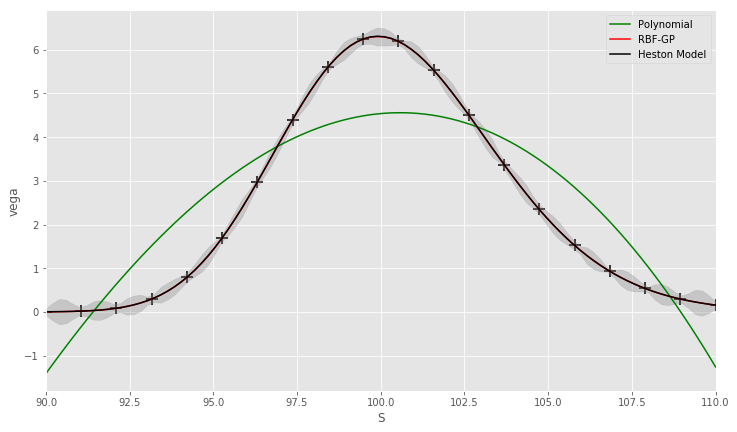

In [24]:
# plot with cov band
up = predict_mean - 2 * (np.sqrt(np.diag(var)))   # 95% confident interval 
down = predict_mean + 2 * (np.sqrt(np.diag(var)))

plt.figure(figsize = (12, 7), facecolor='white', edgecolor='black')
plt.grid(True)
plt.xlim(90, 110)
plt.xlabel('S')
plt.ylabel('vega')
plt.plot(test_x, y_poly, color = 'g', label = 'Polynomial')
plt.plot(test_x, predict_mean, color = 'red', label = 'RBF-GP')
plt.plot(test_x, test_y, color = 'black', label = 'Heston Model')
plt.scatter(train_x, train_y, s = 150, color = 'black', marker = "+")
plt.fill_between(test_x.flatten(), up, down, color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})

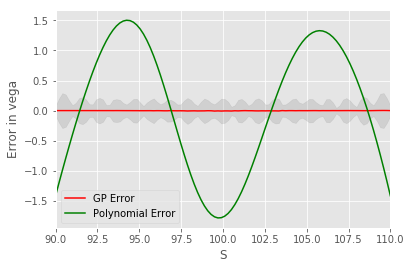

In [25]:
# plot with cov band 
up = predict_mean - 2 * (np.sqrt(np.diag(var)))   # 95% confident interval 
down = predict_mean + 2 * (np.sqrt(np.diag(var)))

plt.figure(facecolor='white', edgecolor='black')
plt.plot(test_x, predict_mean-test_y, color = 'red', label = 'GP Error')
plt.plot(test_x, y_poly.flatten()-test_y, color = 'green', label = 'Polynomial Error')
#plt.plot(train_x, train_y, color = 'black', label = 'Analytical Model')
#plt.scatter(test_x, test_y, s = 150, color = 'black', marker = "+")
plt.fill_between(test_x.flatten(), up-test_y, down - test_y, color = 'grey', alpha=0.2)
plt.grid(True)
plt.xlim(90, 110)
plt.xlabel('S')
plt.ylabel('Error in vega')
plt.legend(loc = 'best', prop={'size':10})

# Convergence study

In [418]:
# Convergency check with multiple training sets
mse = []
params = []

In [930]:
training_number = 130   # change training size 
train_x = np.array(np.linspace(90,110, training_number), dtype='float32').reshape(training_number, 1)
train_y = []
for S in train_x:
    train_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))
    
testing_number = 100
test_x = np.array(np.linspace(90,110, testing_number), dtype='float32').reshape(testing_number, 1)
test_y = []
for S in test_x:
    test_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

In [931]:
x0 =[0.1, 0.01] # initial value
bounds=[ [0.001, 1.0], [0.001, 0.1]]     #construct the bounds in the form of constraints
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)
    
    
res = minimize(llk2, x0, method='COBYLA', constraints=cons, options={'gtol': 1e-16, 'disp': True})
res

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: OptimizeWarning: Unknown solver options: gtol
  


-556.738703992
78.2123136315
-437.63119151
-217.845916467
-534.177031117
-488.451507924
-553.742135781
-546.762568104
-556.361254956
-554.79432695
-556.691477673
-555.857889435
-556.72903099


     fun: 6.9330288399584496e-310
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 13
  status: 1
 success: True
       x: array([ 0.1 ,  0.01])

In [439]:
params.append(res.x)
params

[array([ 1. ,  0.1]),
 array([ 1. ,  0.1]),
 array([ 1. ,  0.1]),
 array([ 0.99997426,  0.00158468])]

In [919]:
l = np.float(res.x[0])
noise_term = np.float(res.x[1])

Kernel = rbf(train_x, lengthscale=l).eval()
K_noise = Kernel + np.eye(training_number) * noise_term  # without noise, the cov band converge to 0 at the training points 
k_s = rbf(test_x, train_x).eval()                   
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_y))
predict_mean = np.dot(k_s, alpha)

# cov
v = np.linalg.solve(L, k_s.T)
var = rbf(test_x).eval() - np.dot(v.T, v)

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


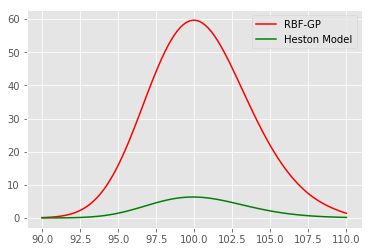

In [920]:
up = predict_mean - 2 * (np.sqrt(np.diag(var)))   # 95% confident interval 
down = predict_mean + 2 * (np.sqrt(np.diag(var)))


plt.figure(facecolor='white', edgecolor='black')
plt.plot(test_x, predict_mean, color = 'red', label = 'RBF-GP')
plt.plot(test_x, test_y, color = 'green', label = 'Heston Model')
plt.fill_between(test_x.flatten(), up, down, color = 'grey', alpha=0.3)
plt.grid(True)
plt.legend()

In [547]:
np.mean((predict_mean - test_y )**2)

0.06461859769471133

In [442]:
mse.append(np.mean((predict_mean - test_y )**2)) 
mse

[4.2783958338876831,
 0.17255430321600509,
 0.034108076640463968,
 6.4916527575206081e-06]

Text(0,0.5,'MSE')

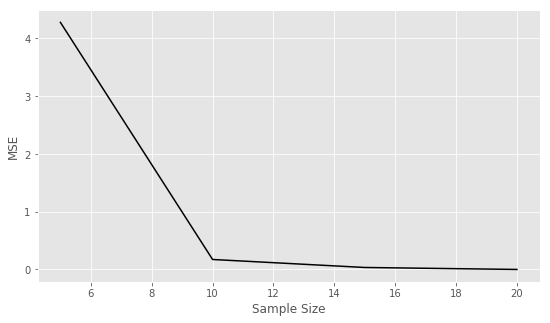

In [446]:
plt.figure(figsize = (9,5),facecolor='white', edgecolor='black')
n_train = np.array([5, 10, 15, 20])  # convergency plot against number of training set
plt.plot(n_train, mse, color='black') 
plt.grid(True)
plt.xlabel('Sample Size')
plt.ylabel('MSE')

With optimization of noise term and lengthscale, we can obtain much better prediction and smaller MSE even with small number of training data.
Compare with convergence test with optimization, it takes around 250 training data without optimization to achieve same prediction power of 10 training data with optimization. 

Text(0,0.5,'MSE')

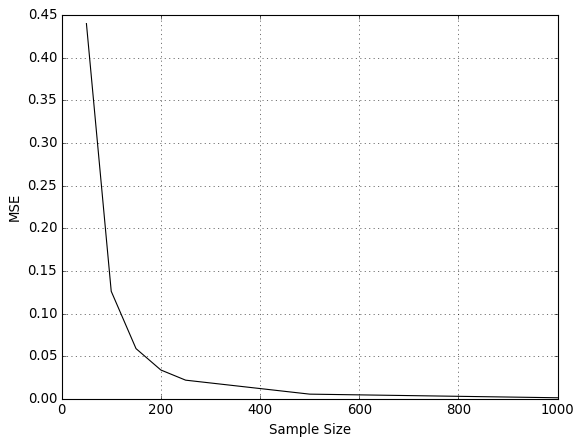

In [571]:
# Convergence test without optimizaiton.
plt.figure(facecolor='white', edgecolor='black')
n_training = np.array([50, 100, 150, 200, 250, 500, 1000])   # convergency plot against number of training set
plt.plot(n_training, mse, color='black') 
plt.grid(True)
plt.xlabel('Sample Size')
plt.ylabel('MSE')

# Using sklearn for Heston Vegas

In [19]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [982]:
para=[]
error = []

In [35]:
# everytime before change training_number, has to rerun this code, maybe some parameters have been changed when fitting GP by sklearn.
nInt = 256
r0 = 0.0002
S= 100
K = 100
T = 0.01
r = r0
sigma = 0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
V= HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)

vegas = []
S_arr = np.arange(90,110,0.1)
for S in S_arr:
    vegas.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt));

In [36]:
training_number = 10  # change training size 
train_x = np.array(np.linspace(90,110, training_number), dtype='float32').reshape(training_number, 1)
train_y = []
for S in train_x:
    train_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))
    
testing_number = 100
test_x = np.array(np.linspace(90,110, testing_number), dtype='float32').reshape(testing_number, 1)
test_y = []
for S in test_x:
    test_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

In [37]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0)) 
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel)
gp.fit(train_x,train_y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [38]:
#para.append(gp.kernel_)
#para
gp.kernel_

RBF(length_scale=1)

In [39]:
y_pred, sigma = gp.predict(test_x, return_std=True)
#error.append(np.mean((y_pred - test_y)**2))

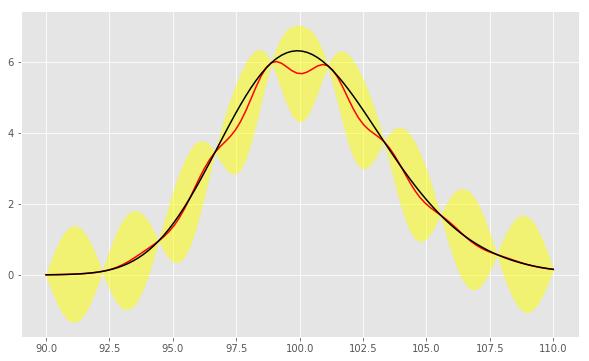

In [40]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(test_x.flatten(), y_pred, color = 'red')
plt.plot(test_x.flatten(), test_y, color = 'black')
#plt.scatter(train_x, train_y, color = 'green') 
plt.fill_between(test_x.flatten(), (y_pred-2*sigma), (y_pred+2*sigma), color = 'yellow', alpha=0.5)

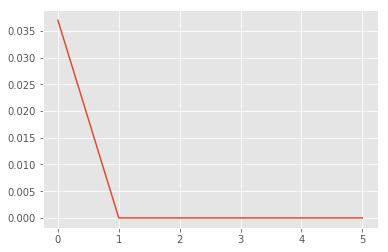

In [1033]:
size = np.array([10, 20, 50, 100, 200, 500])
plt.plot(error)

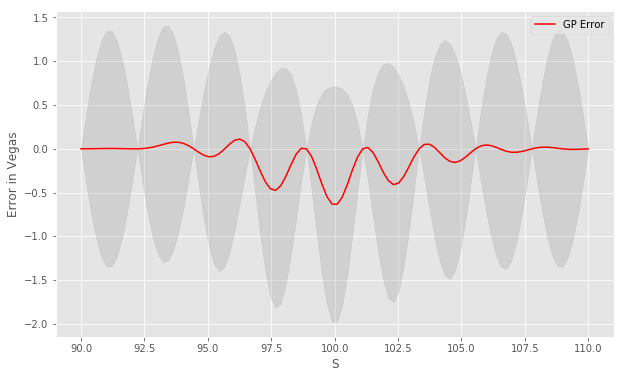

In [41]:
# Errors in GP prediction
up = y_pred - 2 * sigma   # 95% confident interval 
down = y_pred + 2 * sigma

plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(test_x, y_pred - test_y, color = 'red', label = 'GP Error')
#plt.plot(train_x, train_y, color = 'black', label = 'Analytical Model')
#plt.scatter(test_x, test_y, s = 150, color = 'black', marker = "+")
plt.fill_between(test_x.flatten(), up-test_y, down - test_y, color = 'grey', alpha=0.2)
plt.grid(True)
#plt.xlim(90, 110)
plt.xlabel('S')
plt.ylabel('Error in Vegas')
plt.legend(loc = 'best', prop={'size':10})

# HestonCOS

In [42]:
para_HC = []
mse_HC = []

In [87]:
# everytime before change training_number, has to rerun this code, maybe some parameters have been changed when fitting GP by sklearn.
nInt = 256
r0 = 0.0002
S= 100
K = 100
T = 0.01
r = r0
sigma = 0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9

In [45]:
training_number = 90 # change training size 
train_x = np.array(np.linspace(90,110, training_number), dtype='float32').reshape(training_number, 1)
train_y = []
for S in train_x:
    train_y.append(HestonCOS(S,K,1,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))
    
testing_number = 100
test_x = np.array(np.linspace(90,110, testing_number), dtype='float32').reshape(testing_number, 1)
test_y = []
for S in test_x:
    test_y.append(HestonCOS(S,K,1,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

In [46]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0)) 
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel)
gp.fit(train_x,train_y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [47]:
gp.kernel_
#para_HC.append(gp.kernel_)
para_HC

[]

In [48]:
y_pred, sigma = gp.predict(test_x, return_std=True)
#mse_HC.append(np.mean((y_pred - test_y)**2))
mse_HC
#np.mean((y_pred - test_y)**2)

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[]

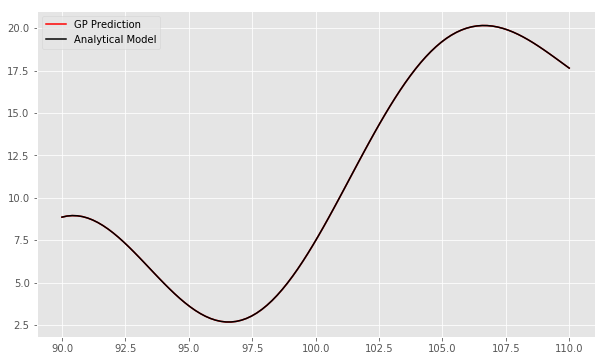

In [49]:
# predictionn plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(test_x.flatten(), y_pred, color = 'red', label = 'GP Prediction')
plt.plot(test_x.flatten(), test_y, color = 'black', label = 'Analytical Model')
#plt.scatter(train_x, train_y, color = 'black', marker = '+', s = 100) 
plt.fill_between(test_x.flatten(), (y_pred-2*sigma), (y_pred+2*sigma), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})

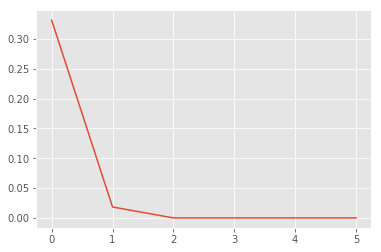

In [1175]:
# convergence plot
plt.plot(mse_HC)

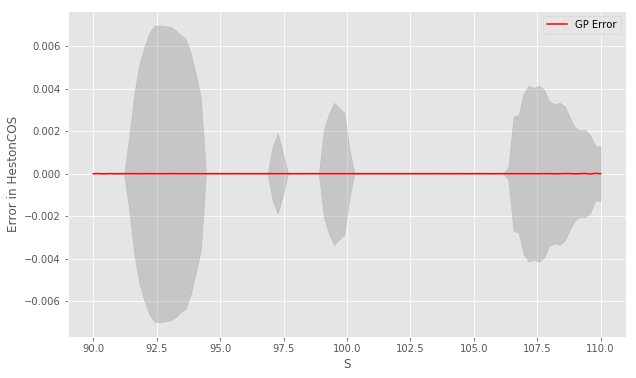

In [50]:
# Error plot
up = y_pred - 2 * sigma   # 95% confident interval 
down = y_pred + 2 * sigma

plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(test_x, y_pred - test_y, color = 'red', label = 'GP Error')
#plt.plot(train_x, train_y, color = 'black', label = 'Analytical Model')
#plt.scatter(test_x, test_y, s = 150, color = 'black', marker = "+")
plt.fill_between(test_x.flatten(), up-test_y, down - test_y, color = 'grey', alpha=0.3)
plt.grid(True)
#plt.xlim(90, 110)
plt.xlabel('S')
plt.ylabel('Error in HestonCOS')
plt.legend(loc = 'best', prop={'size':10})

# Grid v0

In [20]:
nInt = 256
r0 = 0.0002

#p0 = [5.76145232379, 0.393696857573, 0.99999999,-0.686387364593,0.685888435264]
#print Error_Function(p0)

S= 100
K = 100
T = 0.01
r = r0
sigma = 0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
V= HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)

In [21]:
vegas = []
v0_arr = np.array(np.linspace(0.1,5,100))
for v in v0_arr:
    vegas.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v,rho, 'C', N=nInt));

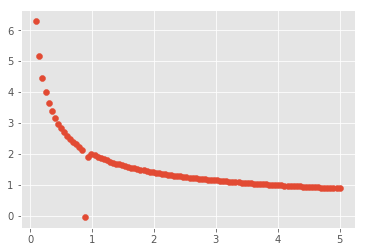

In [22]:
plt.scatter(v0_arr, vegas)

# fit GP on HestonCOS against v0

In [23]:
# Prepare data
training_number = 100 # change training size 
train_x = np.array(np.linspace(0.1, 5, training_number), dtype='float32').reshape(training_number, 1)
train_y = np.zeros(training_number)
for i in range(training_number):
    train_y[i] = HestonCOS(S,K,T,r,sigma,lmbda,meanV,train_x[i],rho, 'C', N=nInt)
    
testing_number = 100
test_x = np.array(np.linspace(0.1, 5, testing_number), dtype='float32').reshape(testing_number, 1)
test_y = np.zeros(testing_number)
for i in range(testing_number):
    test_y[i] = HestonCOS(S,K,T,r,sigma,lmbda,meanV,test_x[i],rho, 'C', N=nInt)
    
#diff_x = np.array(np.linspace(0.1, 5, testing_number), dtype='float32').reshape(testing_number, 1)

In [24]:
# using derivative function
from scipy.misc import derivative

In [37]:
def predictive_HC(v0):
    l = 1.
    noise_term = 1e-4

    Kernel = rbf(train_x, lengthscale=l).eval()
    K_noise = Kernel + np.eye(training_number) * noise_term   
    k_s = rbf(v0, train_x).eval()                   
    L = np.linalg.cholesky(K_noise)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_y))
    predict_mean = np.dot(k_s, alpha)
    return predict_mean


In [29]:
d_HC = derivative(predictive_HC, test_x)

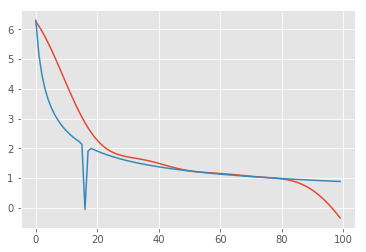

In [30]:
plt.plot(d_HC)
plt.plot(vegas)

using matrix calculation

In [31]:
x0 =[0.1, 0.01] # initial value
bounds=[ [0.001, 1.0], [0.001, 0.1]]     #construct the bounds in the form of constraints
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)
    
    
res = minimize(llk2, x0, method='COBYLA', constraints=cons, options={'gtol': 1e-16, 'disp': True})
res

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: OptimizeWarning: Unknown solver options: gtol
  


-459.938688758
-89.2726968495
-454.409791436
-229.78679544
-454.58472272
-404.5025535
-442.713816857
-452.121179222
-454.04505405
-458.869085322
-459.048990044
-459.72863714
-459.752218251


     fun: 6.9417895844216435e-310
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 13
  status: 1
 success: True
       x: array([ 0.1 ,  0.01])

In [32]:
l = np.float(res.x[0])
noise_term = np.float(res.x[1])

Kernel = rbf(train_x, lengthscale=l).eval()
K_y = Kernel + np.eye(training_number) * noise_term 
L = scipy.linalg.cho_factor(K_y)
alpha = scipy.linalg.cho_solve(L, train_y)
k_s = rbf(test_x, train_x).eval()
k_s_prime = np.dot(((test_x/(l**2)) - train_x).T, k_s)

In [33]:
k_s_prime.shape, alpha.shape

((1, 100), (100,))

In [34]:
partial_f = np.dot(alpha.reshape(1,100).T, k_s_prime)
partial_f.shape

(100, 100)